<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


## 构建数据

In [118]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def plot_history(history, start_epoch=None, end_epoch=None):
    if start_epoch is None:
        start_epoch = 0
    if end_epoch is None:
        end_epoch = len(history.history['loss'])       
            
    max_epoch = min(len(history.history['loss']), end_epoch)
    loss = history.history['loss'][start_epoch:end_epoch]
    val_loss = history.history['val_loss'][start_epoch:end_epoch]
    
    plt.figure(figsize=(8, 5))
    epochs = range(start_epoch, max_epoch)
    if max_epoch <= 20:
        xticks = range(start_epoch, max_epoch)
    else:
        xticks = range(start_epoch, max_epoch, (max_epoch-1)//20+10)

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(xticks)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
def predict(model, series, split_time, window_size):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


def plot_results(x_valid, results):

    plt.figure(figsize=(10, 6))

    plot_series(time_valid, x_valid)
    plot_series(time_valid, results)
    plt.show()    
    
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

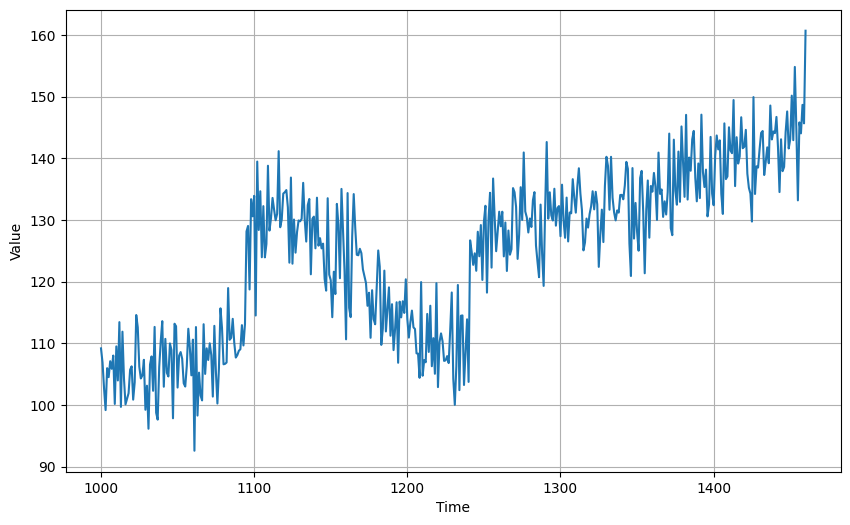

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## 朴素预测 Naive Forecast

In [78]:
naive_forecast = series[split_time - 1:-1]

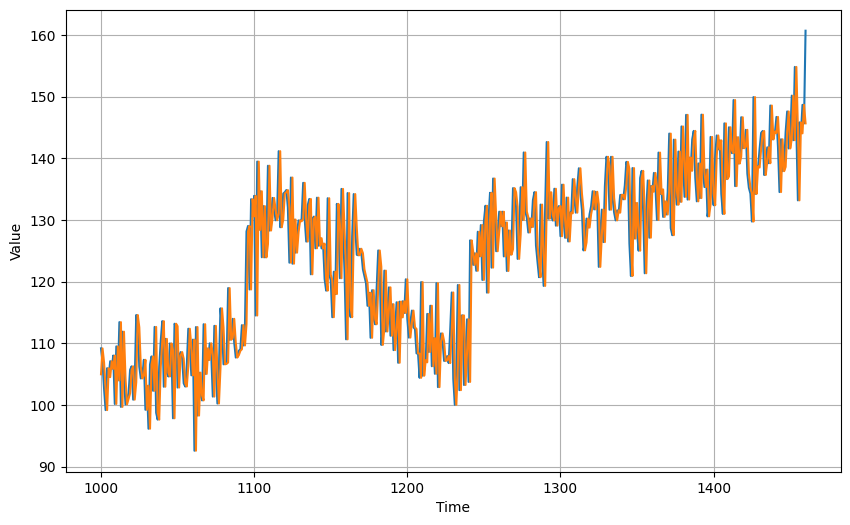

In [79]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show()

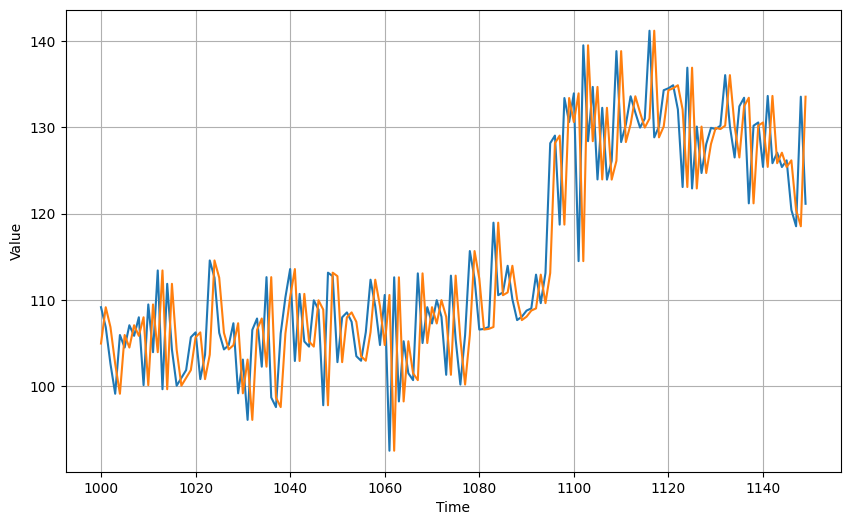

In [80]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)
# plot_series(time_valid, naive_forecast, start=1, end=151)

plt.show()

In [81]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

54.501747
5.799732


##  季节性 + 差分移动平均 

In [82]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

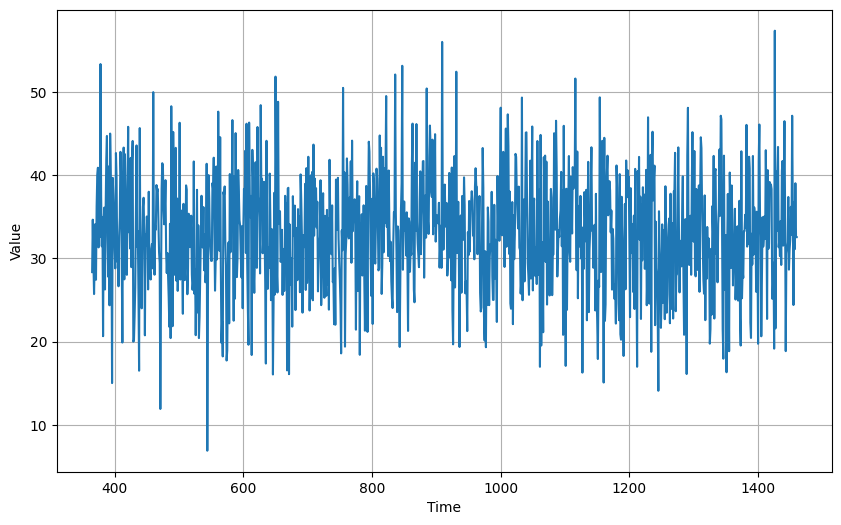

In [83]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

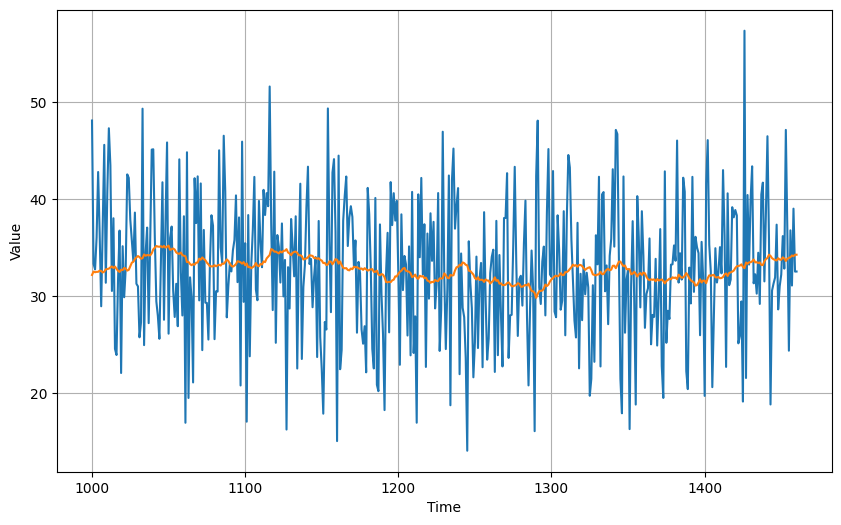

In [84]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

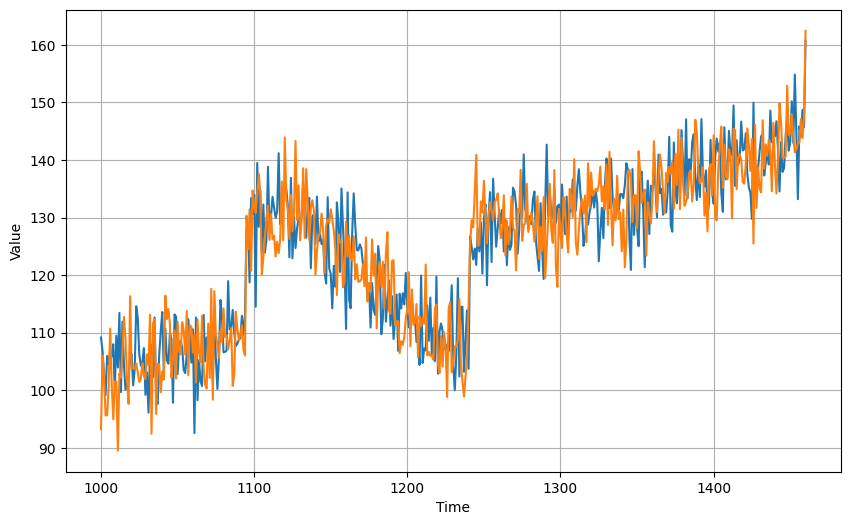

In [85]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [86]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()) 
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.8393106


## 季节性移动平均 + 差分移动平均 

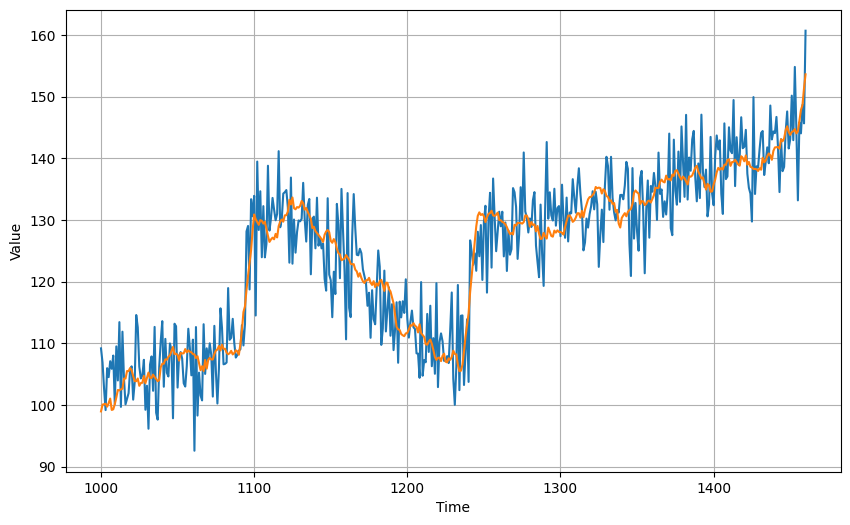

In [87]:
# 需要注意的是，这个移动平均是中心点平均。
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) 
diff_moving_avg_plus_smooth_past = diff_moving_avg_plus_smooth_past + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [88]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()) 
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

29.032827
4.329321


## 单层神经网络

In [77]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# 采用两种优化器，结果差不多。但是SGD看起来收敛的更加平稳
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset,epochs=100, validation_data=val_dataset)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 237.6310 - val_loss: 234.0767
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 109.3796 - val_loss: 107.4679
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 94.1351 - val_loss: 104.7798
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 91.0233 - val_loss: 111.5773
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 90.7346 - val_loss: 126.2879
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 85.0626 - val_loss: 83.4525
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 80.9195 - val_loss: 84.6182
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 84.0783 - val_loss: 78.1406
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 79.2665 - val_loss: 92.5443
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 74.0074 - 

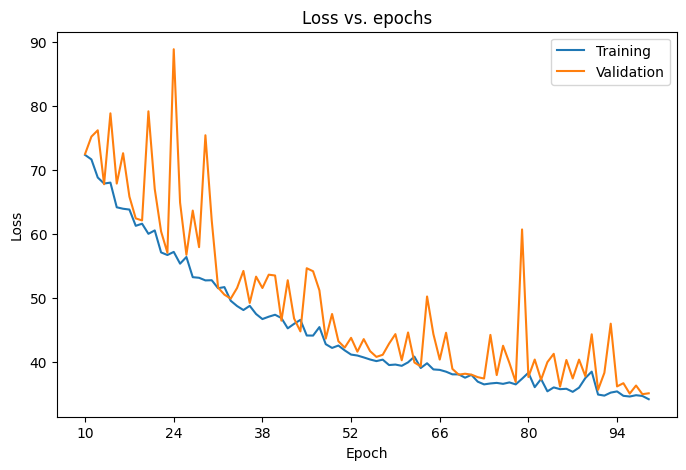

In [89]:
# Plot all but the first 10, 因为前面10次，loss太大了
plot_history(history, start_epoch=10)

上面可以看出，validation数据集的loss非常不稳定

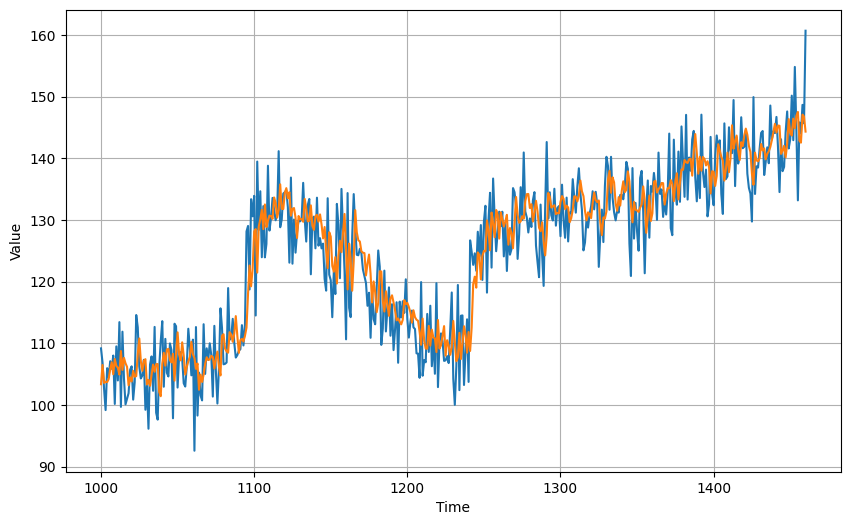

In [90]:
results = predict(model, series, split_time, window_size)
plot_results(x_valid, results)

In [92]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) 

34.5382
4.6797795


## 三层经典神经网络

In [94]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset,epochs=100, validation_data=val_dataset)


Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 844.6835 - val_loss: 41.0906
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 52.9025 - val_loss: 54.6315
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 47.0668 - val_loss: 41.6753
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 47.0195 - val_loss: 55.7290
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 48.9734 - val_loss: 44.9536
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 45.0784 - val_loss: 39.8925
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 45.0904 - val_loss: 40.7827
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 44.3982 - val_loss: 41.6878
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 44.2220 - val_loss: 42.1239
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 44.5197 - val_l

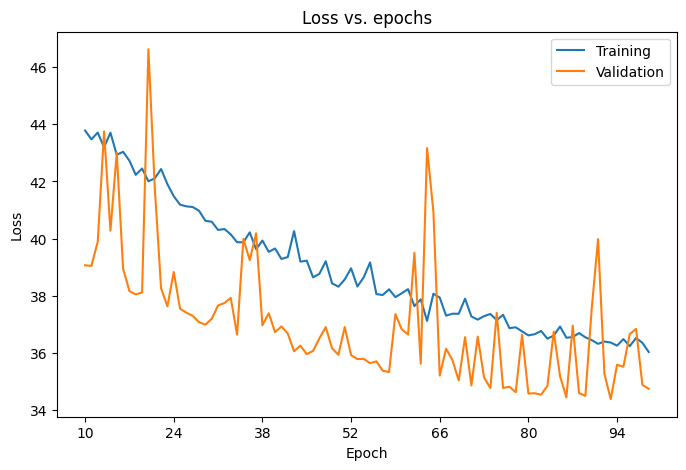

In [95]:
plot_history(history, start_epoch=10)

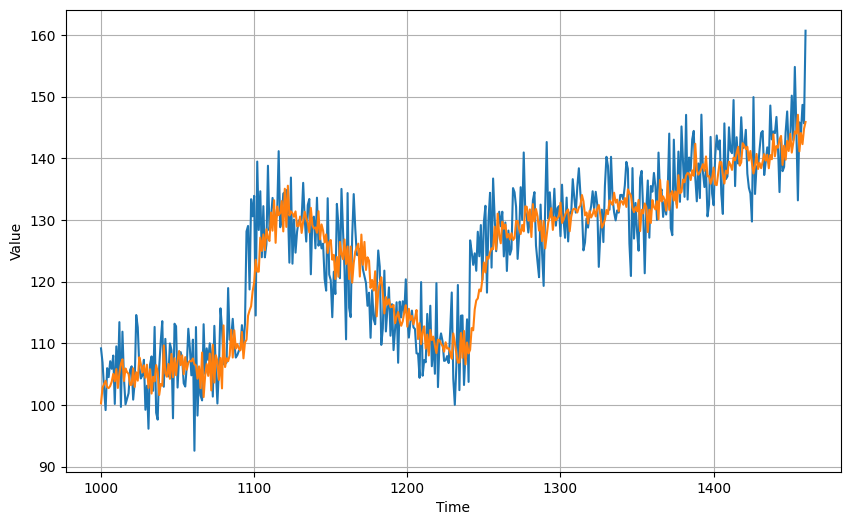

In [99]:
results = predict(model, series, split_time, window_size)
plot_results(x_valid, results)

In [102]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) 

34.098763
4.5841575


## 三层经典神经网络 + LearningRateScheduler

使用LearningRateScheduler模拟学习率的变化。学习率随着epoch而加大，不知道模拟这个的目的何在,似乎是为了能够找到比较适合的学习率。

In [103]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], validation_data=val_dataset)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 4251.6240 - val_loss: 15868.2197 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 4251.3184 - val_loss: 15868.0498 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 4250.9590 - val_loss: 15867.8594 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 4250.5322 - val_loss: 15867.6426 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 4250.0239 - val_loss: 15867.4014 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 4249.3027 - val_loss: 15867.1309 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 4247.9712 - val_loss: 15866.3447 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 4245.7935 - val_loss: 15865.1641 - lr: 2.2387e-08
Epoch 9/100
31/

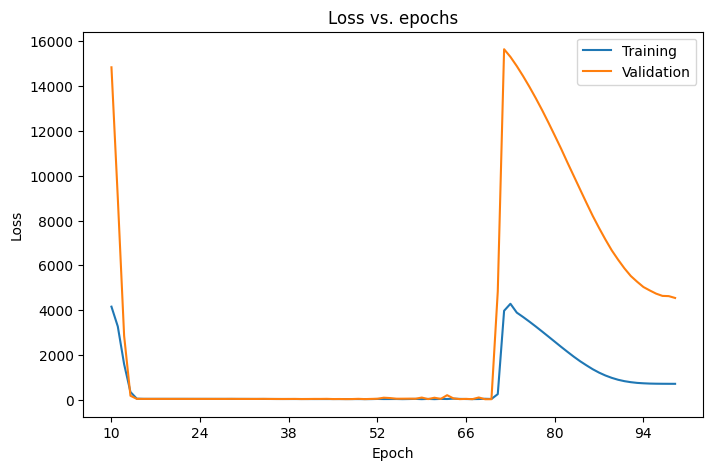

In [104]:
plot_history(history, start_epoch=10)

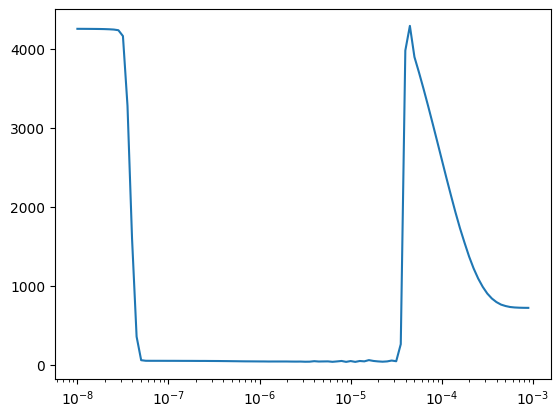

In [105]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

In [106]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) 

34.098763
4.5841575


## 三层经典神经网络 + window_size = 30 + learning_rate=8e-6

In [108]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
# history = model.fit(dataset, epochs=500)
history = model.fit(dataset, epochs=500,  validation_data=val_dataset)

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 1142.1079 - val_loss: 154.5083
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 62.0454 - val_loss: 195.0867
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 61.4788 - val_loss: 173.0685
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 62.6417 - val_loss: 101.8401
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 54.3764 - val_loss: 43.9739
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 50.3771 - val_loss: 59.8513
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 48.2395 - val_loss: 97.6977
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 49.5943 - val_loss: 42.6116
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 50.2584 - val_loss: 45.2453
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 47.4946 - 

Epoch 161/500
31/31 [==============================] - 0s 5ms/step - loss: 34.2706 - val_loss: 48.0283
Epoch 162/500
31/31 [==============================] - 0s 5ms/step - loss: 37.0133 - val_loss: 132.1200
Epoch 163/500
31/31 [==============================] - 0s 5ms/step - loss: 48.0519 - val_loss: 51.0717
Epoch 164/500
31/31 [==============================] - 0s 5ms/step - loss: 38.3842 - val_loss: 46.6524
Epoch 165/500
31/31 [==============================] - 0s 5ms/step - loss: 35.5264 - val_loss: 38.3798
Epoch 166/500
31/31 [==============================] - 0s 5ms/step - loss: 33.7940 - val_loss: 49.6442
Epoch 167/500
31/31 [==============================] - 0s 7ms/step - loss: 33.1776 - val_loss: 33.7135
Epoch 168/500
31/31 [==============================] - 0s 5ms/step - loss: 33.9290 - val_loss: 36.7728
Epoch 169/500
31/31 [==============================] - 0s 5ms/step - loss: 34.4015 - val_loss: 57.1496
Epoch 170/500
31/31 [==============================] - 0s 5ms/step - los

31/31 [==============================] - 0s 5ms/step - loss: 34.9846 - val_loss: 46.0133
Epoch 320/500
31/31 [==============================] - 0s 5ms/step - loss: 39.8047 - val_loss: 41.6521
Epoch 321/500
31/31 [==============================] - 0s 5ms/step - loss: 35.4266 - val_loss: 36.5180
Epoch 322/500
31/31 [==============================] - 0s 5ms/step - loss: 38.2590 - val_loss: 53.1602
Epoch 323/500
31/31 [==============================] - 0s 5ms/step - loss: 34.2572 - val_loss: 39.5224
Epoch 324/500
31/31 [==============================] - 0s 5ms/step - loss: 34.1790 - val_loss: 51.9615
Epoch 325/500
31/31 [==============================] - 0s 5ms/step - loss: 33.8185 - val_loss: 60.9110
Epoch 326/500
31/31 [==============================] - 0s 5ms/step - loss: 34.8019 - val_loss: 58.2248
Epoch 327/500
31/31 [==============================] - 0s 5ms/step - loss: 32.8338 - val_loss: 37.6757
Epoch 328/500
31/31 [==============================] - 0s 6ms/step - loss: 33.3914 - va

31/31 [==============================] - 0s 6ms/step - loss: 35.2153 - val_loss: 44.1691
Epoch 478/500
31/31 [==============================] - 0s 6ms/step - loss: 32.8590 - val_loss: 37.6972
Epoch 479/500
31/31 [==============================] - 0s 5ms/step - loss: 32.7397 - val_loss: 33.7450
Epoch 480/500
31/31 [==============================] - 0s 5ms/step - loss: 37.8788 - val_loss: 33.8125
Epoch 481/500
31/31 [==============================] - 0s 5ms/step - loss: 37.5168 - val_loss: 33.8837
Epoch 482/500
31/31 [==============================] - 0s 5ms/step - loss: 54.9058 - val_loss: 64.2192
Epoch 483/500
31/31 [==============================] - 0s 5ms/step - loss: 35.7313 - val_loss: 33.6390
Epoch 484/500
31/31 [==============================] - 0s 5ms/step - loss: 34.4686 - val_loss: 51.4262
Epoch 485/500
31/31 [==============================] - 0s 5ms/step - loss: 36.9638 - val_loss: 104.5519
Epoch 486/500
31/31 [==============================] - 0s 5ms/step - loss: 35.2925 - v

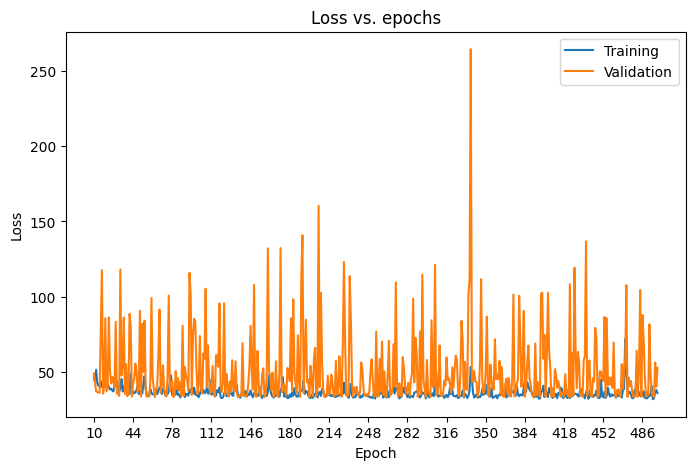

In [109]:
plot_history(history, start_epoch=10)

模型效果好像更加不好，原因何在呢？

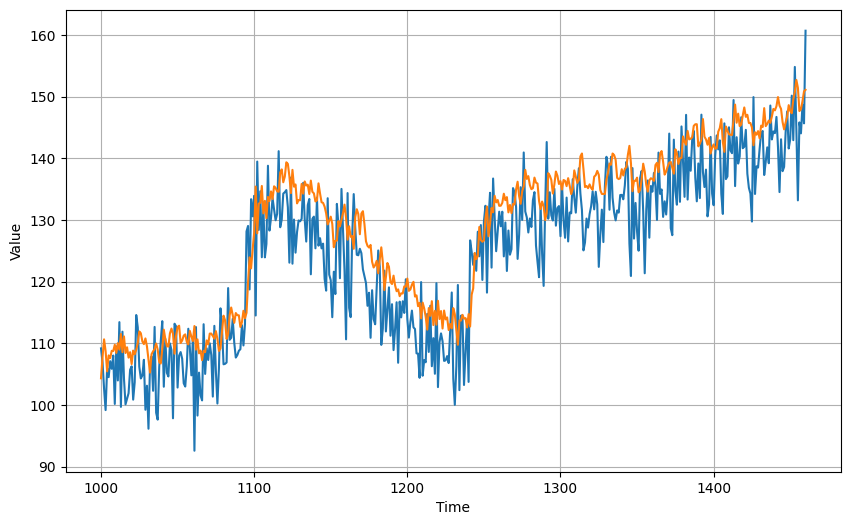

In [110]:
results = predict(model, series, split_time, window_size)
plot_results(x_valid, results)

In [111]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) 

51.854565
6.0072107


In [119]:
# 为何这个值和上面的不同？可能和dataset有一定关系。
model.evaluate(val_dataset)

14/14 [==============================] - 0s 4ms/step - loss: 52.8875


52.8874626159668

In [121]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import models, layers, initializers

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

def get_model(rnn_layer):
    inputs = layers.Input(shape=(3, 4))
    x = rnn_layer(inputs)
    model = models.Model(inputs=inputs, outputs=x)
    return model

def predict(rnn_layer, data):
    outputs = get_model(rnn_layer).predict(data)
    print('-'*40, type(rnn_layer).__name__, '-'*40)
    if isinstance(outputs, list):  
        for output in outputs:
            print(output, output.shape)
    else:
        print(outputs, outputs.shape)
    
np.random.seed(2021)
data = np.random.rand(2, 3, 4)
print(data) 

[[[0.60597828 0.73336936 0.13894716 0.31267308]
  [0.99724328 0.12816238 0.17899311 0.75292543]
  [0.66216051 0.78431013 0.0968944  0.05857129]]

 [[0.96239599 0.61655744 0.08662996 0.56127236]
  [0.61652471 0.96384302 0.57430429 0.37116085]
  [0.45214524 0.20185025 0.56930512 0.19509597]]]


In [130]:
rnn_layer = layers.SimpleRNN(units=5, 
                             kernel_initializer = initializers.RandomNormal(seed=2021),
                             recurrent_initializer = initializers.RandomNormal(seed=2021)
                            )
predict(rnn_layer, data)

rnn_layer = layers.LSTM(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021)
                       )
predict(rnn_layer, data)

rnn_layer = layers.GRU(units=5, 
                       kernel_initializer = initializers.RandomNormal(seed=2021),
                       recurrent_initializer = initializers.RandomNormal(seed=2021)
                      )
predict(rnn_layer, data)

---------------------------------------- SimpleRNN ----------------------------------------
[[-0.0285279   0.03120861  0.07531789  0.01132741  0.02176426]
 [-0.03186165 -0.01342235  0.0295305   0.02772398  0.06187904]] (2, 5)
---------------------------------------- LSTM ----------------------------------------
[[ 0.04448791  0.01470043  0.01533474  0.00228011 -0.01964177]
 [ 0.03495632  0.02616856  0.01668413 -0.018771   -0.01857188]] (2, 5)
---------------------------------------- GRU ----------------------------------------
[[-0.00920612  0.02662001 -0.00036411 -0.04655524 -0.04729844]
 [-0.0094258  -0.00558373 -0.00528645 -0.04308207 -0.02305606]] (2, 5)


In [131]:
rnn_layer = layers.SimpleRNN(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_sequences = True
                       )
predict(rnn_layer, data)

rnn_layer = layers.LSTM(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_sequences = True
                       )
predict(rnn_layer, data)

rnn_layer = layers.GRU(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_sequences = True
                       )
predict(rnn_layer, data)

---------------------------------------- SimpleRNN ----------------------------------------
[[[ 0.00939235  0.11290843  0.02135389  0.005265   -0.02679082]
  [ 0.1055878   0.08867252 -0.00096324  0.05823892 -0.0294642 ]
  [ 0.00258154  0.1060132   0.02538672 -0.00789798 -0.01629386]]

 [[ 0.0489315   0.13186345  0.00714973  0.02947392 -0.02243672]
  [ 0.02967986  0.11626098  0.05767033  0.00915417 -0.07158493]
  [ 0.0547336   0.01948041  0.04628691  0.03286382 -0.05164246]]] (2, 3, 5)
---------------------------------------- LSTM ----------------------------------------
[[[-0.02018269 -0.00819299 -0.02190104  0.00836523  0.01613527]
  [-0.05340337 -0.02133415 -0.05429271  0.03214056  0.0197314 ]
  [-0.05513273 -0.01973507 -0.06113549  0.02963587  0.03452789]]

 [[-0.03168553 -0.01207244 -0.03437678  0.01895954  0.01520991]
  [-0.05147141 -0.02163568 -0.05357936  0.01985161  0.03632383]
  [-0.05850371 -0.02359715 -0.06218331  0.02315541  0.04152252]]] (2, 3, 5)
-------------------------

In [132]:
rnn_layer = layers.SimpleRNN(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_state=True)
predict(rnn_layer, data)

rnn_layer = layers.LSTM(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_state=True)
predict(rnn_layer, data)

rnn_layer = layers.GRU(units=5, 
                       kernel_initializer = initializers.RandomNormal(seed=2021),
                       recurrent_initializer = initializers.RandomNormal(seed=2021),
                       return_state=True)
predict(rnn_layer, data)

---------------------------------------- SimpleRNN ----------------------------------------
[[-0.0617438   0.06745705 -0.00293209  0.00637022 -0.06236606]
 [-0.086666    0.06812856 -0.00257944 -0.02956194 -0.03903535]] (2, 5)
[[-0.0617438   0.06745705 -0.00293209  0.00637022 -0.06236606]
 [-0.086666    0.06812856 -0.00257944 -0.02956194 -0.03903535]] (2, 5)
---------------------------------------- LSTM ----------------------------------------
[[0.02267772 0.02764056 0.00683601 0.00163977 0.00403302]
 [0.01771103 0.0338547  0.01616539 0.00420824 0.00502058]] (2, 5)
[[0.02267772 0.02764056 0.00683601 0.00163977 0.00403302]
 [0.01771103 0.0338547  0.01616539 0.00420824 0.00502058]] (2, 5)
[[0.045442   0.05360377 0.01378471 0.00319338 0.00794604]
 [0.0340765  0.06762662 0.03269957 0.0083015  0.00986715]] (2, 5)
---------------------------------------- GRU ----------------------------------------
[[-0.00899692  0.01311045  0.00244674 -0.00665589 -0.01724976]
 [ 0.01484216  0.03082098  0.003

In [133]:
rnn_layer = layers.SimpleRNN(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_sequences=True,
                        return_state=True)
predict(rnn_layer, data)
rnn_layer = layers.LSTM(units=5, 
                        kernel_initializer = initializers.RandomNormal(seed=2021),
                        recurrent_initializer = initializers.RandomNormal(seed=2021),
                        return_sequences=True,
                        return_state=True)
predict(rnn_layer, data)

rnn_layer = layers.GRU(units=5, 
                       kernel_initializer = initializers.RandomNormal(seed=2021),
                       recurrent_initializer = initializers.RandomNormal(seed=2021),
                       return_sequences=True,
                       return_state=True)
predict(rnn_layer, data)

---------------------------------------- SimpleRNN ----------------------------------------
[[[-0.00998733 -0.065806    0.0145515  -0.1309997  -0.07916445]
  [ 0.01022252 -0.03950518 -0.04337302 -0.09229603 -0.0948052 ]
  [ 0.01518443 -0.06909852  0.03861012 -0.11121247 -0.06336152]]

 [[-0.01239694 -0.06154354 -0.01256139 -0.1482219  -0.09937636]
  [ 0.0262557  -0.11414647  0.04429442 -0.13842726 -0.11976667]
  [ 0.04155384 -0.06356911  0.02955753 -0.01649251 -0.07962431]]] (2, 3, 5)
[[ 0.01518443 -0.06909852  0.03861012 -0.11121247 -0.06336152]
 [ 0.04155384 -0.06356911  0.02955753 -0.01649251 -0.07962431]] (2, 5)
---------------------------------------- LSTM ----------------------------------------
[[[ 0.00656236 -0.00317245 -0.01395946 -0.02435391  0.01956098]
  [ 0.01993299  0.00497759 -0.01688542 -0.05351618  0.02725302]
  [ 0.01651794 -0.00167572 -0.03167358 -0.06586304  0.0406164 ]]

 [[ 0.01096988 -0.00031164 -0.01432458 -0.03590067  0.02090047]
  [ 0.01715009  0.00012661 -0.0